In [104]:
### importing libraries

from datetime import datetime,timedelta
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns

import json
import os
import gc

In [26]:
### seting the data directory

datset_rel_path = 'data/dataset/'

In [27]:
cwd = os.getcwd()
cwd

'/home/sidd/workspace/Student-Stress-Prediction'

In [28]:
label_df = pd.read_csv('./data/label_df.csv')
label_df.head()

,user_id,date_time,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
0,u00,2013-03-25 11:54:00,2013,3,25,11,54,Mon,12,stress_ema,2,1
1,u00,2013-03-25 20:33:00,2013,3,25,20,33,Mon,12,stress_ema,2,1
2,u00,2013-03-26 18:12:00,2013,3,26,18,12,Tue,12,stress_ema,1,0
3,u00,2013-03-27 19:25:00,2013,3,27,19,25,Wed,12,stress_ema,1,0
4,u00,2013-03-28 11:43:00,2013,3,28,11,43,Thu,12,stress_ema,2,1


In [29]:
label_df['date_time'] = pd.to_datetime(label_df['date_time'])
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       2455 non-null   object        
 1   date_time     2455 non-null   datetime64[ns]
 2   year          2455 non-null   int64         
 3   month         2455 non-null   int64         
 4   day           2455 non-null   int64         
 5   hours         2455 non-null   int64         
 6   minute        2455 non-null   int64         
 7   weekday       2455 non-null   object        
 8   weeknumber    2455 non-null   int64         
 9   label_source  2455 non-null   object        
 10  rating        2455 non-null   int64         
 11  stress_label  2455 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 230.3+ KB


## Utility function

In [30]:
# # label_df['date_time'].nunique(),len(label_df)

# dup_sum =0

# for u in label_df['user_id'].unique():
#     t_df = label_df[label_df['user_id'] == u ]
#     uni_en = len(set(t_df['date_time']))
#     en = len(t_df)
#     if uni_en != en:
#         print(u,uni_en,en)
#         dup_sum += en-uni_en

# dup_sum



In [31]:
start_time =  1357032225
# end_time = 1371284625


def get_date_time(timestamp):
  return datetime.fromtimestamp(timestamp).strftime("%m/%d/%Y, %H:%M:%S")

get_date_time(start_time)#,get_date_time(end_time)

'01/01/2013, 01:23:45'

In [32]:
get_date_time(start_time) == get_date_time(start_time)

True

## App usage

In [67]:
app_usage_path = os.path.join(datset_rel_path,'app_usage')

app_usage_files = os.listdir(app_usage_path)
len(app_usage_files)

49

In [68]:
app_usage_files[0].split('_')[-1].split('.')[0]

'u53'

In [69]:
# tmp_li = [get_date_time(start_time)]
# tmp_li.extend(list(label_df[label_df['user_id'] == usr_id].date_time))
# len(tmp_li)

In [74]:
AGGREGATION_DAYS = 1


app_usage_di = defaultdict(list)


for app_usage_file in tqdm(app_usage_files):
    usr_id = app_usage_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(app_usage_path,app_usage_file))

    tmp_df['timestamp'] = tmp_df['timestamp'].apply(lambda x : get_date_time(x))
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])

    # time stamps
    # tmp_li = [get_date_time(start_time)]
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)
    
    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]

        app_usage_di['user_id'].append(usr_id)
        app_usage_di['date_time'].append(time_b)

        app_usage_di['app_usage_baseActivity_mClass'].append(len(set(slice_df['RUNNING_TASKS_baseActivity_mClass'])))
        app_usage_di['app_usage_baseActivity_mPackage'].append(len(set(slice_df['RUNNING_TASKS_baseActivity_mPackage'])))
        app_usage_di['app_usage_baseActivity_id_count'].append(len(set(slice_df['RUNNING_TASKS_id'])))

        app_usage_di['app_usage_baseActivity_numActivities'].append(slice_df['RUNNING_TASKS_numActivities'].sum())
        app_usage_di['app_usage_baseActivity_numRunning'].append(slice_df['RUNNING_TASKS_numRunning'].sum())

        app_usage_di['app_usage_topActivity_mClass'].append(len(set(slice_df['RUNNING_TASKS_topActivity_mClass'])))
        app_usage_di['app_usage_topActivity_mPackage'].append(len(set(slice_df['RUNNING_TASKS_topActivity_mPackage'])))



100%|██████████| 49/49 [00:17<00:00,  2.76it/s]


In [75]:
for k,val in app_usage_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
app_usage_baseActivity_mClass 2455
app_usage_baseActivity_mPackage 2455
app_usage_baseActivity_id_count 2455
app_usage_baseActivity_numActivities 2455
app_usage_baseActivity_numRunning 2455
app_usage_topActivity_mClass 2455
app_usage_topActivity_mPackage 2455


In [82]:
app_usage_df = pd.DataFrame(app_usage_di)

app_usage_df.to_csv('./data/app_usage_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

/tmp/ipykernel_2385507/2405099644.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(app_usage_df.corr())


<AxesSubplot: >

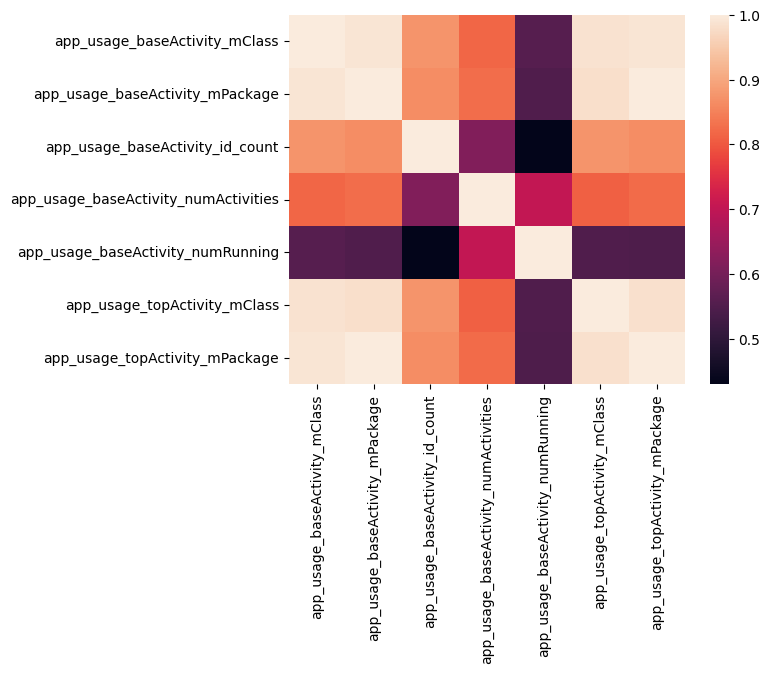

In [80]:
sns.heatmap(app_usage_df.corr())

## Activity

In [83]:
activity_path = os.path.join(datset_rel_path,'sensing','activity')

activity_files = os.listdir(activity_path)
len(activity_files)

49

In [84]:
activity_files[0].split('_')[-1].split('.')[0]

'u17'

In [105]:
AGGREGATION_DAYS = 1


activity_di = defaultdict(list)


for activity_file in tqdm(activity_files):
    usr_id = activity_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(activity_path,activity_file))

    tmp_df['timestamp'] = tmp_df['timestamp'].apply(lambda x : get_date_time(x))
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    
    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]

        activity_di['user_id'].append(usr_id)
        activity_di['date_time'].append(time_b)

        tmp_di = dict(slice_df[' activity inference'].value_counts())

        activity_di['activity_inf_stationary_count'].append(tmp_di.get(0,0))
        activity_di['activity_inf_walking_count'].append(tmp_di.get(1,0))
        activity_di['activity_inf_running_count'].append(tmp_di.get(2,0))
        activity_di['activity_inf_unknown_count'].append(tmp_di.get(3,0))


    gc.collect()



100%|██████████| 49/49 [18:16<00:00, 22.38s/it]


In [109]:
for k,val in activity_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
activity_inf_stationary_count 2455
activity_inf_walking_count 2455
activity_inf_running_count 2455
activity_inf_unknown_count 2455


In [106]:
activity_df = pd.DataFrame(activity_di)

In [107]:
activity_df = pd.DataFrame(activity_di)

activity_df.to_csv('./data/activity_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

/tmp/ipykernel_2385507/1194580611.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(activity_df.corr())


<AxesSubplot: >

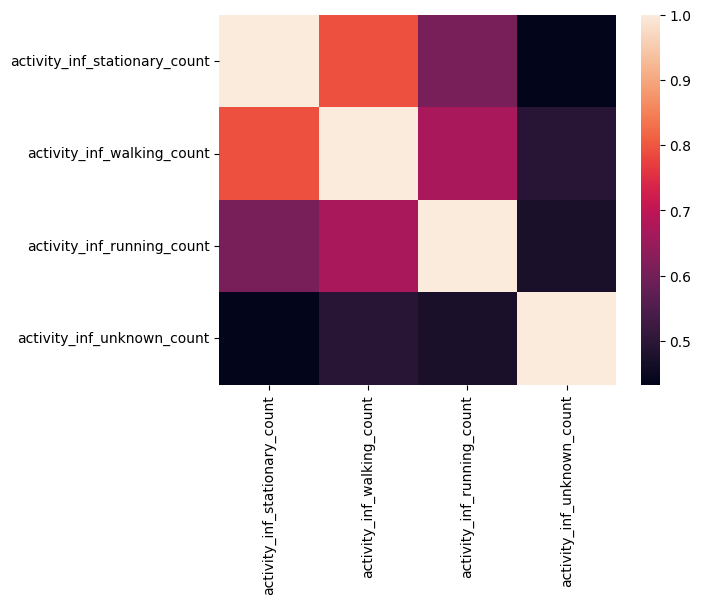

In [108]:
sns.heatmap(activity_df.corr())

In [111]:
usr_id

'u33'

In [110]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423140 entries, 0 to 423139
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   timestamp            423140 non-null  datetime64[ns]
 1    activity inference  423140 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.5 MB


## Audio

In [112]:
audio_path = os.path.join(datset_rel_path,'sensing','audio')

audio_files = os.listdir(audio_path)
len(audio_files)

49

In [113]:
audio_files[0].split('_')[-1].split('.')[0]

'u14'

In [154]:
AGGREGATION_DAYS = 1


audio_di = defaultdict(list)


for audio_file in tqdm(audio_files):
    usr_id = audio_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(audio_path,audio_file))

    tmp_df['timestamp'] = tmp_df['timestamp'].apply(lambda x : get_date_time(x))
    tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]

        audio_di['user_id'].append(usr_id)
        audio_di['date_time'].append(time_b)

        tmp_di = dict(slice_df[' audio inference'].value_counts())

        audio_di['audio_inf_silence_count'].append(tmp_di.get(0,0))
        audio_di['audio_inf_voice_count'].append(tmp_di.get(1,0))
        audio_di['audio_inf_noise_count'].append(tmp_di.get(2,0))
        audio_di['audio_inf_unknown_count'].append(tmp_di.get(3,0))


    gc.collect()



In [ ]:
for k,val in audio_di.items():
    print(k,len(val))

user_id 47
date_time 47
audio_inf_silence_count 47
audio_inf_voice_count 47
audio_inf_noise_count 47
audio_inf_unknown_count 47


In [118]:
audio_df = pd.DataFrame(audio_di)

In [ ]:
audio_df = pd.DataFrame(audio_di)

audio_df.to_csv('./data/audio_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

In [ ]:
sns.heatmap(activity_df.corr())

## Conversation

In [121]:
conv_path = os.path.join(datset_rel_path,'sensing','conversation')

conv_files = os.listdir(conv_path)
len(conv_files)

49

In [122]:
conv_files[0].split('a')[-1].split('.')[0]

'u08'

In [173]:
AGGREGATION_DAYS = 1


conv_di = defaultdict(list)


for conv_file in tqdm(conv_files):
    usr_id = conv_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(conv_path,conv_file))

    tmp_df['start_timestamp'] = tmp_df['start_timestamp'].apply(lambda x : get_date_time(x))
    tmp_df['start_timestamp'] = pd.to_datetime(tmp_df['start_timestamp'])

    tmp_df[' end_timestamp'] = tmp_df[' end_timestamp'].apply(lambda x : get_date_time(x))
    tmp_df[' end_timestamp'] = pd.to_datetime(tmp_df[' end_timestamp'])

    tmp_df['conv_dur'] = tmp_df[' end_timestamp'] - tmp_df['start_timestamp']

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.start_timestamp) & (tmp_df[' end_timestamp']< time_b)]

        conv_di['user_id'].append(usr_id)
        conv_di['date_time'].append(time_b)
        conv_di['conversation_hours'].append(slice_df['conv_dur'].sum().seconds//3600)
        conv_di['conversation_minutes'].append(slice_df['conv_dur'].sum().seconds//60)


        # tmp_di = dict(slice_df[' audio inference'].value_counts())

        # conv_di['audio_inf_silence_count'].append(tmp_di.get(0,0))
        # conv_di['audio_inf_voice_count'].append(tmp_di.get(1,0))
        # conv_di['audio_inf_noise_count'].append(tmp_di.get(2,0))
        # conv_di['audio_inf_unknown_count'].append(tmp_di.get(3,0))


    gc.collect()



100%|██████████| 49/49 [00:19<00:00,  2.53it/s]


In [174]:
for k,val in conv_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
conversation_hours 2455
conversation_minutes 2455


In [175]:
conv_df = pd.DataFrame(conv_di)

In [176]:
conv_df.head()

,user_id,date_time,conversation_hours,conversation_minutes
0,u08,2013-03-26 19:04:00,0,0
1,u08,2013-03-26 20:16:00,0,0
2,u08,2013-03-26 23:15:00,0,11
3,u08,2013-03-27 02:11:00,0,11
4,u08,2013-03-27 10:06:00,2,157


In [177]:
conv_df.to_csv('./data/conv_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

/tmp/ipykernel_2385507/930043110.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(conv_df.corr())


<AxesSubplot: >

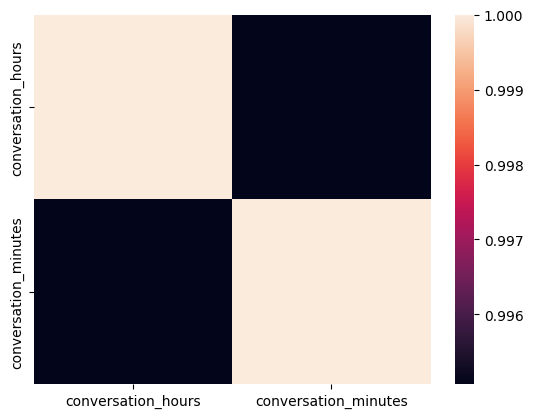

In [178]:
sns.heatmap(conv_df.corr())

## Dark

In [160]:
dark_path = os.path.join(datset_rel_path,'sensing','dark')

dark_files = os.listdir(dark_path)
len(dark_files)

49

In [ ]:
dark_files[0].split('a')[-1].split('.')[0]


In [171]:
AGGREGATION_DAYS = 1


dark_di = defaultdict(list)


for dark_file in tqdm(dark_files):
    usr_id = dark_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(dark_path,dark_file))

    tmp_df['start'] = tmp_df['start'].apply(lambda x : get_date_time(x))
    tmp_df['start'] = pd.to_datetime(tmp_df['start'])

    tmp_df['end'] = tmp_df['end'].apply(lambda x : get_date_time(x))
    tmp_df['end'] = pd.to_datetime(tmp_df['end'])

    tmp_df['dark_dur'] = tmp_df['end'] - tmp_df['start']

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.start) & (tmp_df['end']< time_b)]

        dark_di['user_id'].append(usr_id)
        dark_di['date_time'].append(time_b)
        dark_di['dark_hours'].append(slice_df['dark_dur'].sum().seconds//3600)
        dark_di['dark_minutes'].append(slice_df['dark_dur'].sum().seconds//60)
        dark_di['dark_seconds'].append(slice_df['dark_dur'].sum().seconds)


        # tmp_di = dict(slice_df[' audio inference'].value_counts())

        # conv_di['audio_inf_silence_count'].append(tmp_di.get(0,0))
        # conv_di['audio_inf_voice_count'].append(tmp_di.get(1,0))
        # conv_di['audio_inf_noise_count'].append(tmp_di.get(2,0))
        # conv_di['audio_inf_unknown_count'].append(tmp_di.get(3,0))


    gc.collect()



100%|██████████| 49/49 [00:13<00:00,  3.65it/s]


In [179]:
for k,val in dark_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
dark_hours 2455
dark_minutes 2455
dark_seconds 2455


In [182]:
dark_df = pd.DataFrame(dark_di)

In [183]:
dark_df.head()

,user_id,date_time,dark_hours,dark_minutes,dark_seconds
0,u41,2013-03-31 16:12:00,2,149,8989
1,u41,2013-04-03 18:43:00,3,219,13140
2,u41,2013-04-03 23:00:00,4,296,17795
3,u41,2013-04-08 22:47:00,0,0,0
4,u41,2013-04-13 15:00:00,5,315,18944


In [184]:
dark_df.to_csv('./data/dark_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

## Phone charge

In [185]:
phonecharge_path = os.path.join(datset_rel_path,'sensing','phonecharge')

phonecharge_files = os.listdir(phonecharge_path)
len(phonecharge_files)

49

In [187]:
phonecharge_files[0].split('_')[-1].split('.')[0]


'u46'

In [188]:
AGGREGATION_DAYS = 1


phonecharge_di = defaultdict(list)


for phonecharge_file in tqdm(phonecharge_files):
    usr_id = phonecharge_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(phonecharge_path,phonecharge_file))

    tmp_df['start'] = tmp_df['start'].apply(lambda x : get_date_time(x))
    tmp_df['start'] = pd.to_datetime(tmp_df['start'])

    tmp_df['end'] = tmp_df['end'].apply(lambda x : get_date_time(x))
    tmp_df['end'] = pd.to_datetime(tmp_df['end'])

    tmp_df['phonecharge_dur'] = tmp_df['end'] - tmp_df['start']

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.start) & (tmp_df['end']< time_b)]

        phonecharge_di['user_id'].append(usr_id)
        phonecharge_di['date_time'].append(time_b)
        phonecharge_di['phonecharge_hours'].append(slice_df['phonecharge_dur'].sum().seconds//3600)
        phonecharge_di['phonecharge_minutes'].append(slice_df['phonecharge_dur'].sum().seconds//60)
        phonecharge_di['phonecharge_seconds'].append(slice_df['phonecharge_dur'].sum().seconds)


        # tmp_di = dict(slice_df[' audio inference'].value_counts())

        # conv_di['audio_inf_silence_count'].append(tmp_di.get(0,0))
        # conv_di['audio_inf_voice_count'].append(tmp_di.get(1,0))
        # conv_di['audio_inf_noise_count'].append(tmp_di.get(2,0))
        # conv_di['audio_inf_unknown_count'].append(tmp_di.get(3,0))


    gc.collect()



100%|██████████| 49/49 [00:13<00:00,  3.64it/s]


In [189]:
for k,val in phonecharge_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
phonecharge_hours 2455
phonecharge_minutes 2455
phonecharge_seconds 2455


In [190]:
phonecharge_df = pd.DataFrame(phonecharge_di)

In [191]:
phonecharge_df.head()

,user_id,date_time,phonecharge_hours,phonecharge_minutes,phonecharge_seconds
0,u46,2013-03-31 17:20:00,1,60,3612
1,u46,2013-03-31 20:56:00,3,219,13172
2,u46,2013-03-31 22:05:00,3,219,13172
3,u46,2013-03-31 23:03:00,3,219,13172
4,u46,2013-04-01 02:05:00,5,305,18343


In [192]:
phonecharge_df.to_csv('./data/phonecharge_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

## Phone lock

In [193]:
phonelock_path = os.path.join(datset_rel_path,'sensing','phonelock')

phonelock_files = os.listdir(phonelock_path)
len(phonelock_files)

49

In [194]:
phonelock_files[0].split('_')[-1].split('.')[0]


'u42'

In [195]:
AGGREGATION_DAYS = 1


phonelock_di = defaultdict(list)


for phonelock_file in tqdm(phonelock_files):
    usr_id = phonelock_file.split('_')[-1].split('.')[0]
    
    # print(usr_id)
    
    tmp_df = pd.read_csv(os.path.join(phonelock_path,phonelock_file))

    tmp_df['start'] = tmp_df['start'].apply(lambda x : get_date_time(x))
    tmp_df['start'] = pd.to_datetime(tmp_df['start'])

    tmp_df['end'] = tmp_df['end'].apply(lambda x : get_date_time(x))
    tmp_df['end'] = pd.to_datetime(tmp_df['end'])

    tmp_df['phonelock_dur'] = tmp_df['end'] - tmp_df['start']

    # time stamps
    
    tmp_li = list(label_df[label_df['user_id'] == usr_id].date_time)

    for time_b in tmp_li:
        # print(time_a,time_b)
        # if time_a == time_b:
        #     print(time_a,time_b)
        
        time_a = time_b - timedelta(days=AGGREGATION_DAYS)
        slice_df = tmp_df[(time_a < tmp_df.start) & (tmp_df['end']< time_b)]

        phonelock_di['user_id'].append(usr_id)
        phonelock_di['date_time'].append(time_b)
        phonelock_di['phonelock_hours'].append(slice_df['phonelock_dur'].sum().seconds//3600)
        phonelock_di['phonelock_minutes'].append(slice_df['phonelock_dur'].sum().seconds//60)
        phonelock_di['phonelock_seconds'].append(slice_df['phonelock_dur'].sum().seconds)


    gc.collect()



100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


In [196]:
for k,val in phonelock_di.items():
    print(k,len(val))

user_id 2455
date_time 2455
phonelock_hours 2455
phonelock_minutes 2455
phonelock_seconds 2455


In [197]:
phonelock_df = pd.DataFrame(phonelock_di)

In [198]:
phonelock_df.head()

,user_id,date_time,phonelock_hours,phonelock_minutes,phonelock_seconds
0,u42,2013-04-02 05:10:00,9,540,32439
1,u42,2013-04-02 19:27:00,16,979,58798
2,u42,2013-04-02 19:36:00,16,979,58798
3,u42,2013-04-02 23:57:00,17,1079,64774
4,u42,2013-04-03 17:14:00,19,1162,69724


In [199]:
phonelock_df.to_csv('./data/phonelock_lag_'+str(AGGREGATION_DAYS)+'_df.csv',index = False)

In [200]:
audio_df = pd.read_csv('./data/audio_lag_1_df.csv')
audio_df.head()

,user_id,date_time,audio_inf_silence_count,audio_inf_voice_count,audio_inf_noise_count,audio_inf_unknown_count
0,u00,2013-03-25 11:54:00,0,0,0,0
1,u00,2013-03-25 20:33:00,0,0,0,0
2,u00,2013-03-26 18:12:00,0,0,0,0
3,u00,2013-03-27 19:25:00,12685,9036,3231,0
4,u00,2013-03-28 11:43:00,17686,15644,6832,0


In [207]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  2455 non-null   object        
 1   date_time                2455 non-null   datetime64[ns]
 2   audio_inf_silence_count  2455 non-null   int64         
 3   audio_inf_voice_count    2455 non-null   int64         
 4   audio_inf_noise_count    2455 non-null   int64         
 5   audio_inf_unknown_count  2455 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 115.2+ KB


In [206]:
audio_df['date_time'] = pd.to_datetime(audio_df['date_time'])

## Merging sensing data

In [204]:
len(label_df),len(activity_df),len(app_usage_df)

(2455, 2455, 2455)

In [221]:
merged_sensing_df = activity_df.merge(app_usage_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,app_usage_topActivity_mPackage
0,u17,2013-03-28 15:08:00,7712,372,64,105,6,6,10,295,294,8,6
1,u17,2013-03-30 16:06:00,8090,103,0,28,10,9,19,456,378,11,9
2,u17,2013-04-11 16:53:00,7808,362,15,78,7,6,8,372,372,7,6
3,u17,2013-04-14 15:33:00,8181,117,0,29,6,6,6,895,517,8,6
4,u17,2013-04-15 14:07:00,7413,572,83,158,15,14,22,608,550,16,14


In [222]:
len(merged_sensing_df)

2455

In [223]:
merged_sensing_df = merged_sensing_df.merge(audio_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,app_usage_topActivity_mPackage,audio_inf_silence_count,audio_inf_voice_count,audio_inf_noise_count,audio_inf_unknown_count
0,u17,2013-03-28 15:08:00,7712,372,64,105,6,6,10,295,294,8,6,20608,9849,3073,0
1,u17,2013-03-30 16:06:00,8090,103,0,28,10,9,19,456,378,11,9,19975,12252,2197,0
2,u17,2013-04-11 16:53:00,7808,362,15,78,7,6,8,372,372,7,6,21027,9877,3789,0
3,u17,2013-04-14 15:33:00,8181,117,0,29,6,6,6,895,517,8,6,17791,3995,6022,0
4,u17,2013-04-15 14:07:00,7413,572,83,158,15,14,22,608,550,16,14,17780,8824,7129,0


In [224]:
len(merged_sensing_df),len(merged_sensing_df.columns)

(2455, 17)

In [225]:
merged_sensing_df = merged_sensing_df.merge(conv_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,app_usage_topActivity_mPackage,audio_inf_silence_count,audio_inf_voice_count,audio_inf_noise_count,audio_inf_unknown_count,conversation_hours,conversation_minutes
0,u17,2013-03-28 15:08:00,7712,372,64,105,6,6,10,295,294,8,6,20608,9849,3073,0,4,260
1,u17,2013-03-30 16:06:00,8090,103,0,28,10,9,19,456,378,11,9,19975,12252,2197,0,3,217
2,u17,2013-04-11 16:53:00,7808,362,15,78,7,6,8,372,372,7,6,21027,9877,3789,0,4,244
3,u17,2013-04-14 15:33:00,8181,117,0,29,6,6,6,895,517,8,6,17791,3995,6022,0,1,118
4,u17,2013-04-15 14:07:00,7413,572,83,158,15,14,22,608,550,16,14,17780,8824,7129,0,7,450


In [226]:
len(merged_sensing_df),len(merged_sensing_df.columns)

(2455, 19)

In [227]:
merged_sensing_df = merged_sensing_df.merge(dark_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,app_usage_topActivity_mPackage,audio_inf_silence_count,audio_inf_voice_count,audio_inf_noise_count,audio_inf_unknown_count,conversation_hours,conversation_minutes,dark_hours,dark_minutes,dark_seconds
0,u17,2013-03-28 15:08:00,7712,372,64,105,6,6,10,295,...,6,20608,9849,3073,0,4,260,7,455,27345
1,u17,2013-03-30 16:06:00,8090,103,0,28,10,9,19,456,...,9,19975,12252,2197,0,3,217,14,844,50648
2,u17,2013-04-11 16:53:00,7808,362,15,78,7,6,8,372,...,6,21027,9877,3789,0,4,244,12,774,46467
3,u17,2013-04-14 15:33:00,8181,117,0,29,6,6,6,895,...,6,17791,3995,6022,0,1,118,18,1086,65194
4,u17,2013-04-15 14:07:00,7413,572,83,158,15,14,22,608,...,14,17780,8824,7129,0,7,450,10,625,37535


In [228]:
len(merged_sensing_df)

2455

In [229]:
merged_sensing_df = merged_sensing_df.merge(phonecharge_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,audio_inf_noise_count,audio_inf_unknown_count,conversation_hours,conversation_minutes,dark_hours,dark_minutes,dark_seconds,phonecharge_hours,phonecharge_minutes,phonecharge_seconds
0,u17,2013-03-28 15:08:00,7712,372,64,105,6,6,10,295,...,3073,0,4,260,7,455,27345,0,0,0
1,u17,2013-03-30 16:06:00,8090,103,0,28,10,9,19,456,...,2197,0,3,217,14,844,50648,1,107,6478
2,u17,2013-04-11 16:53:00,7808,362,15,78,7,6,8,372,...,3789,0,4,244,12,774,46467,0,0,0
3,u17,2013-04-14 15:33:00,8181,117,0,29,6,6,6,895,...,6022,0,1,118,18,1086,65194,5,336,20179
4,u17,2013-04-15 14:07:00,7413,572,83,158,15,14,22,608,...,7129,0,7,450,10,625,37535,10,621,37275


In [230]:
merged_sensing_df = merged_sensing_df.merge(phonelock_df,on=['user_id','date_time'])

merged_sensing_df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,conversation_minutes,dark_hours,dark_minutes,dark_seconds,phonecharge_hours,phonecharge_minutes,phonecharge_seconds,phonelock_hours,phonelock_minutes,phonelock_seconds
0,u17,2013-03-28 15:08:00,7712,372,64,105,6,6,10,295,...,260,7,455,27345,0,0,0,7,455,27316
1,u17,2013-03-30 16:06:00,8090,103,0,28,10,9,19,456,...,217,14,844,50648,1,107,6478,17,1071,64301
2,u17,2013-04-11 16:53:00,7808,362,15,78,7,6,8,372,...,244,12,774,46467,0,0,0,14,871,52316
3,u17,2013-04-14 15:33:00,8181,117,0,29,6,6,6,895,...,118,18,1086,65194,5,336,20179,16,1006,60406
4,u17,2013-04-15 14:07:00,7413,572,83,158,15,14,22,608,...,450,10,625,37535,10,621,37275,10,659,39568


In [139]:
tmp_df.columns

Index(['start_timestamp', ' end_timestamp', 'conv_dur'], dtype='object')

In [140]:
tmp_df.head()

,start_timestamp,end_timestamp,conv_dur
0,2013-03-26 21:15:17,2013-03-26 21:16:28,0 days 00:01:11
1,2013-03-26 21:40:40,2013-03-26 21:43:11,0 days 00:02:31
2,2013-03-26 21:51:13,2013-03-26 21:54:44,0 days 00:03:31
3,2013-03-26 22:02:15,2013-03-26 22:06:07,0 days 00:03:52
4,2013-03-27 06:54:57,2013-03-27 07:11:45,0 days 00:16:48


In [141]:
time_a,time_b

(Timestamp('2013-03-25 19:04:00'), Timestamp('2013-03-26 19:04:00'))

In [142]:
tmp_df[time_a < tmp_df.start_timestamp]

,start_timestamp,end_timestamp,conv_dur
0,2013-03-26 21:15:17,2013-03-26 21:16:28,0 days 00:01:11
1,2013-03-26 21:40:40,2013-03-26 21:43:11,0 days 00:02:31
2,2013-03-26 21:51:13,2013-03-26 21:54:44,0 days 00:03:31
3,2013-03-26 22:02:15,2013-03-26 22:06:07,0 days 00:03:52
4,2013-03-27 06:54:57,2013-03-27 07:11:45,0 days 00:16:48
...,...,...,...
2555,2013-05-29 03:11:03,2013-05-29 03:33:37,0 days 00:22:34
2556,2013-05-29 03:36:47,2013-05-29 03:42:40,0 days 00:05:53
2557,2013-05-29 03:47:11,2013-05-29 03:48:32,0 days 00:01:21
2558,2013-05-29 03:51:52,2013-05-29 04:04:08,0 days 00:12:16


In [143]:
tmp_df[time_a < tmp_df.start_timestamp]

,start_timestamp,end_timestamp,conv_dur
0,2013-03-26 21:15:17,2013-03-26 21:16:28,0 days 00:01:11
1,2013-03-26 21:40:40,2013-03-26 21:43:11,0 days 00:02:31
2,2013-03-26 21:51:13,2013-03-26 21:54:44,0 days 00:03:31
3,2013-03-26 22:02:15,2013-03-26 22:06:07,0 days 00:03:52
4,2013-03-27 06:54:57,2013-03-27 07:11:45,0 days 00:16:48
...,...,...,...
2555,2013-05-29 03:11:03,2013-05-29 03:33:37,0 days 00:22:34
2556,2013-05-29 03:36:47,2013-05-29 03:42:40,0 days 00:05:53
2557,2013-05-29 03:47:11,2013-05-29 03:48:32,0 days 00:01:21
2558,2013-05-29 03:51:52,2013-05-29 04:04:08,0 days 00:12:16


In [152]:
slice_df['conv_dur'].sum(),slice_df['conv_dur'].sum().seconds//60 ,slice_df['conv_dur'].sum().seconds//3600 

(Timedelta('0 days 07:38:31'), 458, 7)

In [95]:
slice_df.columns

Index(['timestamp', ' activity inference'], dtype='object')

In [99]:
dict(slice_df[' activity inference'].value_counts()).get(0)

7712

In [101]:
pd.DataFrame(activity_di)

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count
0,u17,2013-03-28 15:08:00,7712,372,64,105


In [90]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526248 entries, 0 to 526247
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   timestamp            526248 non-null  datetime64[ns]
 1    activity inference  526248 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.0 MB


In [51]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52526 entries, 0 to 52525
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   id                                   52526 non-null  object        
 1   device                               52526 non-null  object        
 2   timestamp                            52526 non-null  datetime64[ns]
 3   RUNNING_TASKS_baseActivity_mClass    52526 non-null  object        
 4   RUNNING_TASKS_baseActivity_mPackage  52526 non-null  object        
 5   RUNNING_TASKS_id                     52526 non-null  int64         
 6   RUNNING_TASKS_numActivities          52526 non-null  int64         
 7   RUNNING_TASKS_numRunning             52526 non-null  int64         
 8   RUNNING_TASKS_topActivity_mClass     52526 non-null  object        
 9   RUNNING_TASKS_topActivity_mPackage   52526 non-null  object        
dtypes: datetim

In [49]:
tmp_li[0]

Timestamp('2013-03-27 16:51:00')

In [48]:
tmp_li[0] - timedelta(days=1)

Timestamp('2013-03-26 16:51:00')

In [52]:
for t in tmp_li:

    a = t - timedelta(days=1)

    tmp_df

In [53]:

for time_b in tmp_li:
    # print(time_a,time_b)
    # if time_a == time_b:
    #     print(time_a,time_b)
    time_a = t - timedelta(days=1)
    tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]


# tmp_df['timestamp']

In [56]:
tmp_df[(time_a < tmp_df.timestamp) & (tmp_df.timestamp < time_b)]#['RUNNING_TASKS_numActivities'].sum()

,id,device,timestamp,RUNNING_TASKS_baseActivity_mClass,RUNNING_TASKS_baseActivity_mPackage,RUNNING_TASKS_id,RUNNING_TASKS_numActivities,RUNNING_TASKS_numRunning,RUNNING_TASKS_topActivity_mClass,RUNNING_TASKS_topActivity_mPackage
49005,c7f14fae-0091-4dae-abb6-131e211b0aa5-25,b726971b-0950-4a03-8d04-d384063548cf,2013-05-27 01:09:31,com.google.android.apps.paco.PAM,com.google.android.apps.paco,8,1,1,com.google.android.apps.paco.PAM,com.google.android.apps.paco
49006,c7f14fae-0091-4dae-abb6-131e211b0aa5-25,b726971b-0950-4a03-8d04-d384063548cf,2013-05-27 01:09:31,com.android.launcher2.Launcher,com.android.launcher,2,1,1,com.android.launcher2.Launcher,com.android.launcher
49007,c7f14fae-0091-4dae-abb6-131e211b0aa5-25,b726971b-0950-4a03-8d04-d384063548cf,2013-05-27 01:09:31,com.google.android.gm.ConversationListActivity...,com.google.android.gm,9,1,1,com.google.android.gm.ConversationListActivity...,com.google.android.gm
49008,c7f14fae-0091-4dae-abb6-131e211b0aa5-25,b726971b-0950-4a03-8d04-d384063548cf,2013-05-27 01:09:31,com.android.mms.ui.ConversationList,com.android.mms,7,1,1,com.android.mms.ui.ConversationList,com.android.mms
49009,c7f14fae-0091-4dae-abb6-131e211b0aa5-25,b726971b-0950-4a03-8d04-d384063548cf,2013-05-27 01:09:31,com.android.deskclock.DeskClock,com.google.android.deskclock,6,1,1,com.android.deskclock.DeskClock,com.google.android.deskclock
...,...,...,...,...,...,...,...,...,...,...
49861,c20654f7-b519-430c-84a9-6347d467140e-52,b726971b-0950-4a03-8d04-d384063548cf,2013-05-27 07:49:31,com.google.android.gm.ConversationListActivity...,com.google.android.gm,9,1,1,com.google.android.gm.ConversationListActivity...,com.google.android.gm
49862,c20654f7-b519-430c-84a9-6347d467140e-52,b726971b-0950-4a03-8d04-d384063548cf,2013-05-27 07:49:31,com.android.mms.ui.ConversationList,com.android.mms,7,1,1,com.android.mms.ui.ConversationList,com.android.mms
49863,c20654f7-b519-430c-84a9-6347d467140e-52,b726971b-0950-4a03-8d04-d384063548cf,2013-05-27 07:49:31,com.android.deskclock.DeskClock,com.google.android.deskclock,6,1,1,com.android.deskclock.DeskClock,com.google.android.deskclock
49864,c20654f7-b519-430c-84a9-6347d467140e-52,b726971b-0950-4a03-8d04-d384063548cf,2013-05-27 07:49:31,com.google.android.apps.genie.geniewidget.acti...,com.google.android.apps.genie.geniewidget,5,1,1,com.google.android.apps.genie.geniewidget.acti...,com.google.android.apps.genie.geniewidget


In [37]:
# # label_df['date_time'].nunique(),len(label_df)

# dup_sum =0

# for u in label_df['user_id'].unique():
#     t_df = label_df[label_df['user_id'] == u ]
#     uni_en = len(set(t_df['date_time']))
#     en = len(t_df)
#     if uni_en != en:
#         print(u,uni_en,en)
#         dup_sum += en-uni_en

# dup_sum

